# Part 2 - Looking at timeframes of project approvals
- OMG pls work. The idea is to create a machine learning model that will predict how long your approval will take.

In [1210]:
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [1211]:
# define file locations
# approved construction permits
alvaras_file = 'C:/Users/Zaca/Documents/Datasets/lisbon/alvaras/alvaras.shp'

# all processes?
processos_file = 'C:/Users/Zaca/Documents/Datasets/lisbon/alvaras/processos.shp'


alvaras = gp.read_file(alvaras_file)
alvaras['DATA_ENTRA'] = pd.to_datetime(alvaras['DATA_ENTRA'])
alvaras['DATA_ALVAR'] = pd.to_datetime(alvaras['DATA_ALVAR'])
alvaras['DEMORA'] = (alvaras['DATA_ALVAR'] - alvaras['DATA_ENTRA']).dt.days
alvaras = alvaras[alvaras['DATA_ENTRA'] >= '2009-01-01']

alvaras['WEEKDAY'] = [x.weekday() for x in alvaras['DATA_ENTRA']]
alvaras['MONTH'] = alvaras['DATA_ENTRA'].dt.month
alvaras['YEAR'] = alvaras['DATA_ENTRA'].dt.year

In [1212]:
alvaras['ASSUNTO'].fillna('Not specified', inplace=True)

In [1213]:
processos = gp.read_file(processos_file)
processos['DATA_ENTRA'] = pd.to_datetime(processos['DATA_ENTRA'])
processos = processos[processos['FREGUESIA'] != 'Lumiar (Extinta)']

In [1214]:
def into_timeseries(df, dt_col):
    df = df.set_index(dt_col)
    df.index = pd.to_datetime(df.index)
    return df

processos_ts = into_timeseries(processos, 'DATA_ENTRA')

In [1215]:
process_count = processos_ts.resample('MS').count()['OBJECTID'].reset_index()
process_count['STRING_DATE'] = process_count['DATA_ENTRA'].astype('str').str[:-3]
process_count_dict = pd.Series(process_count['OBJECTID'].values, index=process_count['STRING_DATE']).to_dict()

In [1216]:
alvaras['DATA'] = alvaras['DATA_ENTRA'].astype('str').str[:-3]
alvaras['COUNT'] = alvaras['DATA'].map(process_count_dict)

In [1237]:
grouper = processos_ts.groupby([pd.Grouper(freq='MS'), 'FREGUESIA'])
result = grouper['OBJECTID'].count().unstack('FREGUESIA').fillna(0).reset_index()
result['STRING_DATE'] = result['DATA_ENTRA'].astype('str').str[:-3]

result.drop()

FREGUESIA,DATA_ENTRA,Ajuda,Alcântara,Alvalade,Areeiro,Arroios,Avenidas Novas,Beato,Belém,Benfica,...,Misericórdia,Olivais,Parque das Nações,Penha de França,Santa Clara,Santa Maria Maior,Santo António,São Domingos de Benfica,São Vicente,STRING_DATE
0,2009-01-01,2.0,4.0,5.0,4.0,11.0,10.0,5.0,14.0,4.0,...,11.0,6.0,0.0,6.0,1.0,21.0,12.0,2.0,9.0,2009-01
1,2009-02-01,3.0,2.0,4.0,6.0,10.0,13.0,1.0,15.0,3.0,...,29.0,4.0,2.0,4.0,1.0,40.0,16.0,5.0,5.0,2009-02
2,2009-03-01,11.0,6.0,6.0,0.0,13.0,13.0,1.0,14.0,1.0,...,26.0,16.0,1.0,2.0,1.0,13.0,11.0,2.0,5.0,2009-03
3,2009-04-01,2.0,4.0,15.0,9.0,13.0,6.0,0.0,10.0,4.0,...,27.0,4.0,2.0,0.0,3.0,25.0,15.0,3.0,4.0,2009-04
4,2009-05-01,3.0,3.0,5.0,6.0,11.0,13.0,4.0,14.0,5.0,...,17.0,12.0,2.0,3.0,1.0,18.0,13.0,1.0,7.0,2009-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2019-01-01,7.0,4.0,7.0,2.0,14.0,9.0,4.0,13.0,2.0,...,18.0,3.0,3.0,2.0,1.0,24.0,17.0,4.0,6.0,2019-01
121,2019-02-01,14.0,7.0,7.0,5.0,18.0,13.0,2.0,17.0,4.0,...,16.0,3.0,3.0,3.0,1.0,20.0,10.0,2.0,8.0,2019-02
122,2019-03-01,10.0,3.0,7.0,9.0,17.0,18.0,1.0,9.0,4.0,...,10.0,4.0,1.0,3.0,2.0,30.0,21.0,2.0,8.0,2019-03
123,2019-04-01,8.0,4.0,2.0,9.0,16.0,10.0,5.0,10.0,2.0,...,12.0,4.0,3.0,5.0,1.0,18.0,15.0,3.0,9.0,2019-04


In [1238]:
result.columns

Index(['DATA_ENTRA', 'Ajuda', 'Alcântara', 'Alvalade', 'Areeiro', 'Arroios',
       'Avenidas Novas', 'Beato', 'Belém', 'Benfica', 'Campo de Ourique',
       'Campolide', 'Carnide', 'Estrela', 'Lumiar', 'Marvila', 'Misericórdia',
       'Olivais', 'Parque das Nações', 'Penha de França', 'Santa Clara',
       'Santa Maria Maior', 'Santo António', 'São Domingos de Benfica',
       'São Vicente', 'STRING_DATE'],
      dtype='object', name='FREGUESIA')

In [1250]:
for col in result.columns:
    if col not in ['DATA_ENTRA', 'STRING_DATE']:
        print(col)
        map_dict = pd.Series(result[col].values, index=result['STRING_DATE']).to_dict()
        alvaras['test'] = np.where((alvaras['FREGUESIA'] == col)  & (alvaras['test'] == np.nan), alvaras['DATA'].map(map_dict), np.nan)

Ajuda
Alcântara
Alvalade
Areeiro
Arroios
Avenidas Novas
Beato
Belém
Benfica
Campo de Ourique
Campolide
Carnide
Estrela
Lumiar
Marvila
Misericórdia
Olivais
Parque das Nações
Penha de França
Santa Clara
Santa Maria Maior
Santo António
São Domingos de Benfica
São Vicente


In [1251]:
alvaras.head()

,OBJECTID,COD_SIG,IDTIPO,N_PROCESSO,DATA_ENTRA,TIPOLOGIA,MORADA,FREGUESIA,OP_URBANIS,ASSUNTO,...,Shape__Are,Shape__Len,geometry,DEMORA,WEEKDAY,MONTH,YEAR,DATA,COUNT,test
2,13,3100404009001,2,852/EDI/2009,2009-06-19,Edificação,R do Jardim do Regedor 10-32,Santa Maria Maior,Ampliação,Not specified,...,662.744629,107.992681,"POLYGON ((-9.14066 38.71559, -9.14067 38.71560...",502,4,6,2009,2009-06,180,NaN
3,14,4402803033001,2,852/EDI/2010,2010-08-11,Edificação,R Passos Manuel 19-,Arroios,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,554.964355,94.524498,"POLYGON ((-9.13697 38.72794, -9.13696 38.72779...",285,2,8,2010,2010-08,109,NaN
4,15,0100901028001,2,852/EDI/2011,2011-08-16,Edificação,Estr da Cruz 30,Ajuda,Construção,Not specified,...,296.551758,69.374560,"POLYGON ((-9.20697 38.71090, -9.20701 38.71086...",127,1,8,2011,2011-08,126,NaN
5,16,3800804006001,2,852/EDI/2012,2012-08-31,Edificação,R da Madalena 182-182C,Santa Maria Maior,Alteração,Alterações Interiores,...,183.309570,61.931927,"POLYGON ((-9.13619 38.71280, -9.13611 38.71280...",633,4,8,2012,2012-08,120,NaN
6,17,1601502036001,2,852/EDI/2014,2014-07-28,Edificação,Cc do Monte 70-72A,São Vicente,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,320.532227,77.226981,"POLYGON ((-9.13118 38.71846, -9.13125 38.71838...",533,0,7,2014,2014-07,176,NaN


In [1218]:
alvaras.dropna(inplace=True)

In [1219]:
cols = ['FREGUESIA', 'OP_URBANIS', 'PROCEDIMEN', 'DEMORA', 'TIPO_ALVAR', 'ASSUNTO', 'COUNT', 'Shape__Are', 'WEEKDAY', 'MONTH', 'YEAR']
alvaras_ml = alvaras[cols]
cat = ['FREGUESIA', 'OP_URBANIS', 'PROCEDIMEN', 'TIPO_ALVAR', 'ASSUNTO']

In [1220]:
for col in cat:
    alvaras_ml[col] = le.fit_transform(alvaras_ml[col].astype(str))

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1221]:
alvaras_ml

,FREGUESIA,OP_URBANIS,PROCEDIMEN,DEMORA,TIPO_ALVAR,ASSUNTO,COUNT,Shape__Are,WEEKDAY,MONTH,YEAR
2,20,3,2,502,9,7,180,662.744629,4,6,2009
3,4,1,2,285,0,1,109,554.964355,2,8,2010
4,0,4,1,127,7,7,126,296.551758,1,8,2011
5,20,0,2,633,9,3,120,183.309570,4,8,2012
6,23,1,2,533,0,1,176,320.532227,0,7,2014
...,...,...,...,...,...,...,...,...,...,...,...
9323,14,0,1,291,7,2,120,3001.556152,4,8,2012
9324,12,3,2,897,9,7,147,232.627930,0,7,2013
9326,6,1,1,110,0,1,147,80.615723,2,7,2013
9327,15,1,1,31,7,1,176,90.650391,0,7,2014


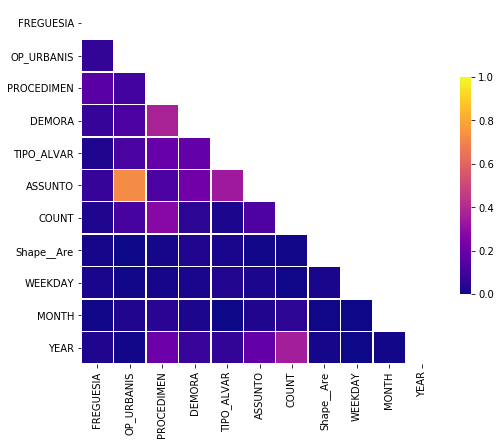

In [1222]:
# now every data is numerical I will compute the correlation matrix to remove colinearity features
corr = alvaras_ml.corr().abs()

# make a heatmap
f, ax = plt.subplots(figsize=(8, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='plasma', vmin=0, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [1223]:
X = alvaras_ml.drop('DEMORA', axis=1)
y = alvaras_ml['DEMORA']

In [1224]:
# scale features
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [1225]:
# make the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1226]:
# initialize linear regression model
lr = LinearRegression()

# fit training data
model = lr.fit(X_train, y_train)

In [1227]:
# get score
model.score(X_test, y_test)

0.2109740477075588

In [1228]:
# random forest regression
for i in range(1, 15):
    rfr = RandomForestRegressor(max_depth=i, random_state=42)
    rfr.fit(X_train, y_train)
    score = rfr.score(X_test, y_test)
    print(i, score)

1 0.15044648965074092
2 0.19367284269726626
3 0.22025742924289982
4 0.268828659657425
5 0.2955144382109751
6 0.303499945335176
7 0.31118446843652636
8 0.3154432018399119
9 0.31297677718414807
10 0.308141544407456
11 0.3038905413732592
12 0.2976546856089326
13 0.29229877755581424
14 0.2859586966336548


In [1229]:
from sklearn.metrics import mean_absolute_error
rfr = RandomForestRegressor(max_depth=8, random_state=42)
rfr.fit(X_train, y_train)
score = rfr.score(X_train, y_train)
print('Train score:', score)
score = rfr.score(X_test, y_test)
print('Test score:', score)

y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
mse_train = mean_absolute_error(y_train, y_pred_train)
mse_test = mean_absolute_error(y_test, y_pred_test)

print('mae train', mse_train)
print('mae test', mse_test)

Train score: 0.4263015336064757
Test score: 0.3154432018399119
mae train 224.14884147082861
mae test 250.68706053628418


In [1230]:
from sklearn.model_selection import cross_val_score

# cross validate the results of the random forest regressor
cv_rfr = cross_val_score(rfr, X, y, cv=10)
cv_rfr

array([0.30318779, 0.26483509, 0.28704137, 0.27901229, 0.2771612 ,
       0.27482739, 0.26663072, 0.31471391, 0.25769983, 0.30319048])

(array([3565., 2050.,  884.,  331.,  159.,   73.,   43.,   19.,   11.,
           4.]),
 array([1.0000e+00, 3.5330e+02, 7.0560e+02, 1.0579e+03, 1.4102e+03,
        1.7625e+03, 2.1148e+03, 2.4671e+03, 2.8194e+03, 3.1717e+03,
        3.5240e+03]),
 <a list of 10 Patch objects>)

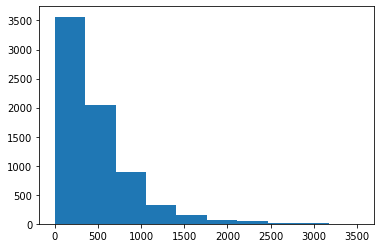

In [1231]:
plt.hist(y)